In [1]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
from datetime import datetime, timedelta
from pydash import py_
from green_city.utils import datetime2index, index2datetime

from green_city.mlflow_config import get_mlflow_config
mlflow.set_tracking_uri(get_mlflow_config()["TRACKING_URI"])
client = MlflowClient()
experiment_id = client.get_experiment_by_name("green_city_experiments").experiment_id

## DB CONNECTION ##
from sqlalchemy import create_engine
from decouple import Config, RepositoryEnv

config = Config(RepositoryEnv("../.db_credentials"))

db_connection_credentials = {
    "database": config('POSTGRES_DB'),
    "user": config('POSTGRES_USER'),
    "password": config('POSTGRES_PASSWORD'),
    "host": config('POSTGRES_HOST'),
    "port": config('POSTGRES_PORT'),
}
DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
db = create_engine(DB_STRING)

In [2]:
run_ids = [r.run_id for r in client.list_run_infos(experiment_id, run_view_type=ViewType.ACTIVE_ONLY)]

all_runs = {run_id: client.get_run(run_id).to_dictionary() for run_id in run_ids}

In [3]:
runs_dict = {}

for id, details in all_runs.items():
    start_time = py_.get(details, "info.start_time")
    end_time = py_.get(details, "info.end_time")
    delta = round(end_time/1000 - start_time/1000, 2)
    runs_dict[id] = {
        "time_s": delta,
        **py_.get(details, "data.metrics"),
        **py_.get(details, "data.params"),
        "run_name": details["data"]["tags"]["mlflow.runName"],
    }

In [4]:
df = pd.DataFrame.from_dict(runs_dict, orient='index')
df = df.astype({"datetime": "datetime64[ns]"})
df = df.assign(index = df['index'].fillna(df.datetime.map(datetime2index))).dropna(subset=["index"])

#if index is not set, assign it from datetime
df.datetime.map(datetime2index).unique()
df = df.astype({"index": "int", "train_steps": "float"})
df.index = df.index.rename("run_id")

#Drop the shorter TBATS models
df = df[np.logical_or(np.logical_not(df.train_steps<1000), df.model!="TBATS")]

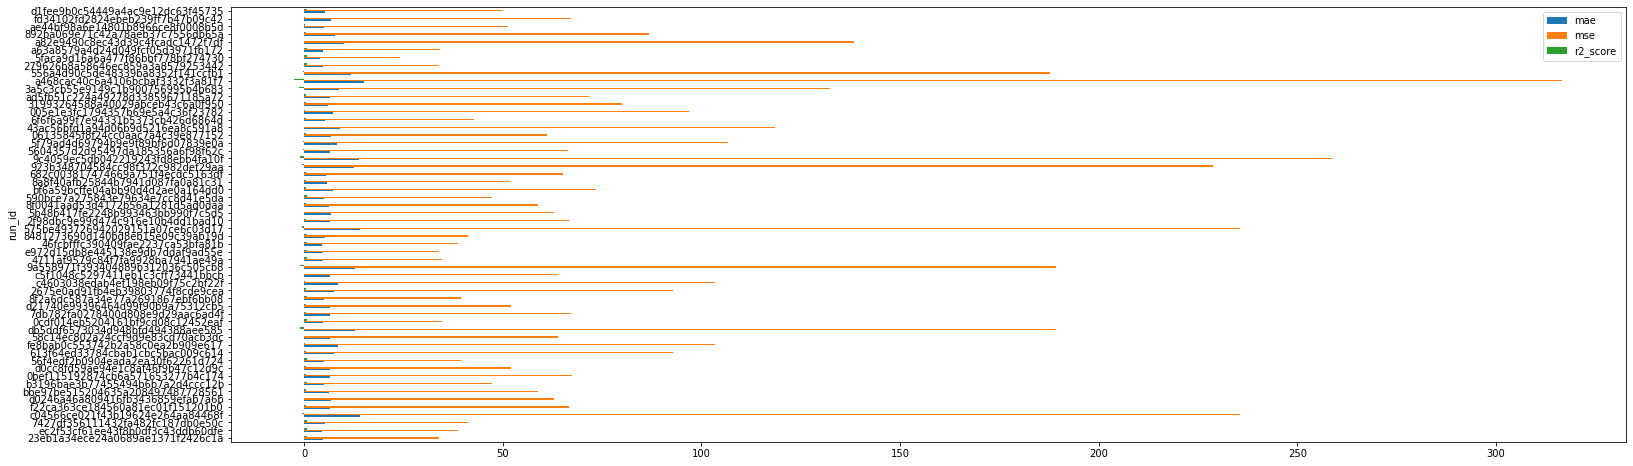

In [5]:
plt.rcParams['figure.figsize'] = [25, 8]
df[df.feature=="net_load_kWh"].loc[:, ["mae", "mse", "r2_score"]].plot.barh()
#df[df.feature=="net_load_kWh"].loc[:, ["time_s"]].plot.barh()
df.to_csv("../data/results/evaluation_matrix.csv")

In [6]:
def row_label(df_row):
    if df_row["model"] == "TBATS":
        if not np.isnan(df_row["train_steps"]):
            return df_row['model'] + " (" + str(int(df_row['train_steps'])) + " trainsteps)"
        else:
            return df_row['model']
    elif df_row["model"] == "sarimax":
        return df_row["run_name"].capitalize().replace("_", " ")
    elif df_row["model"] == "baseline":
        return "baseline (last year)"
    elif df_row["model"] == "linear_regression":
        return "Linear regression"
    else:
        return df_row["model"]
    

df["disp_label"] = df.apply(row_label, axis=1)


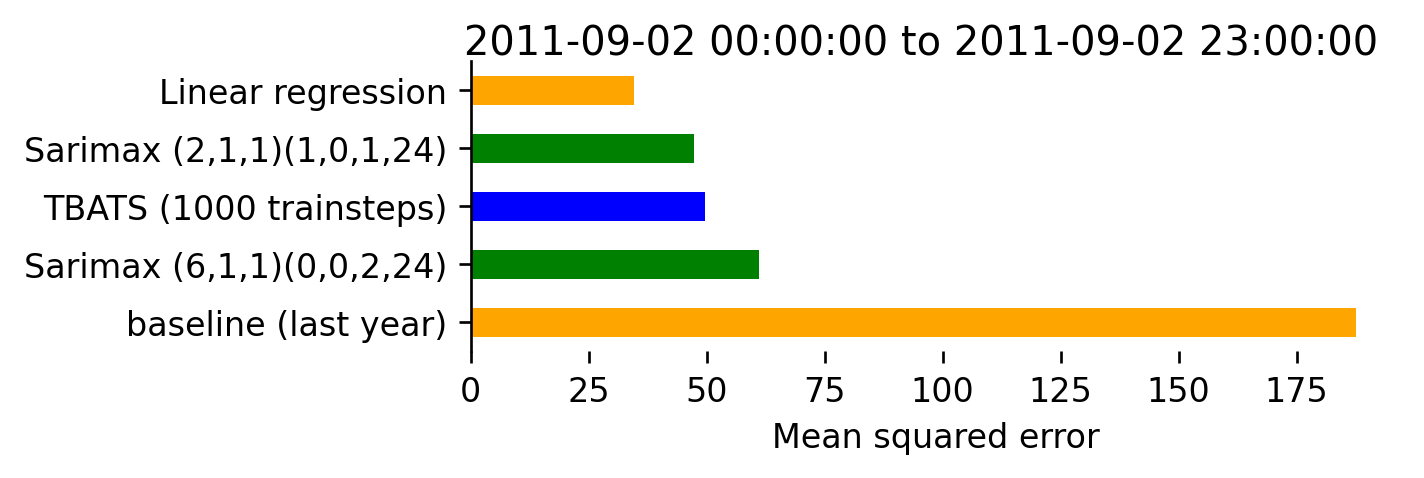

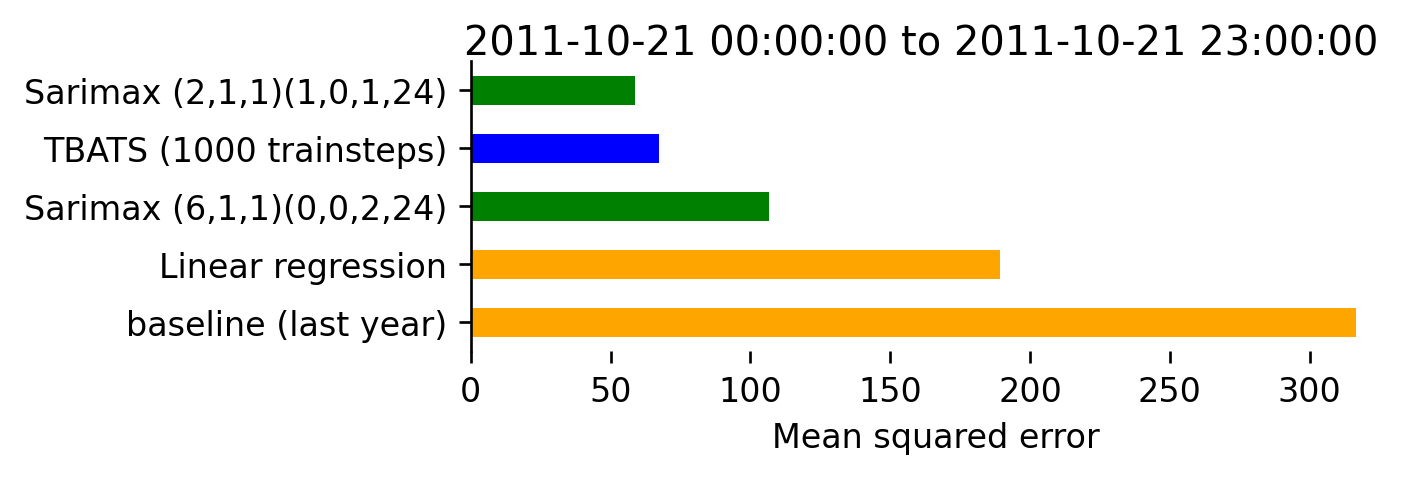

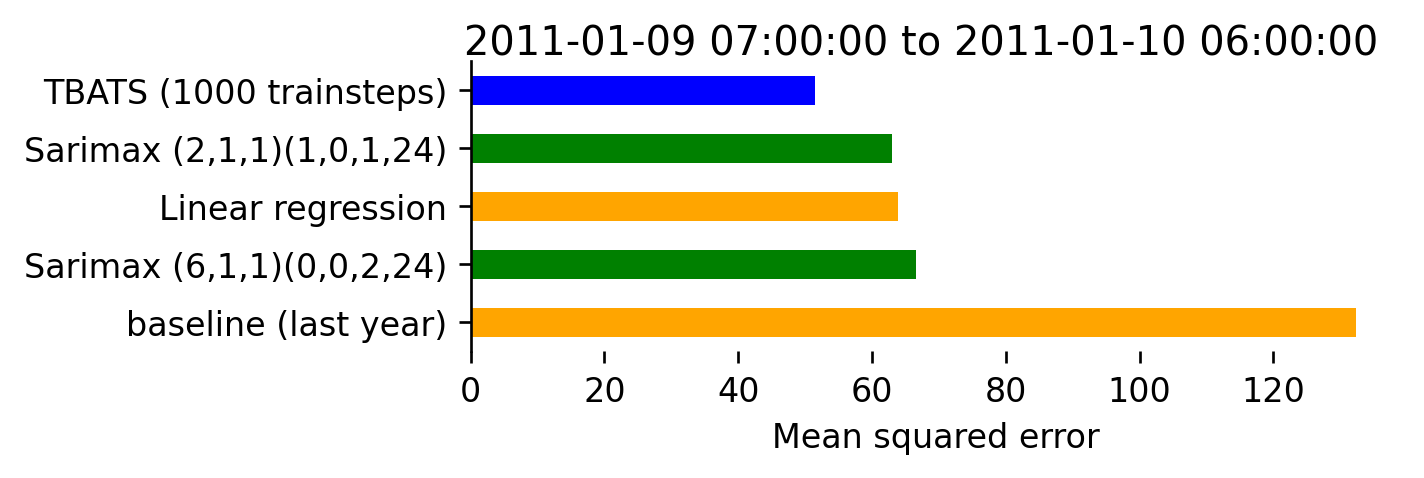

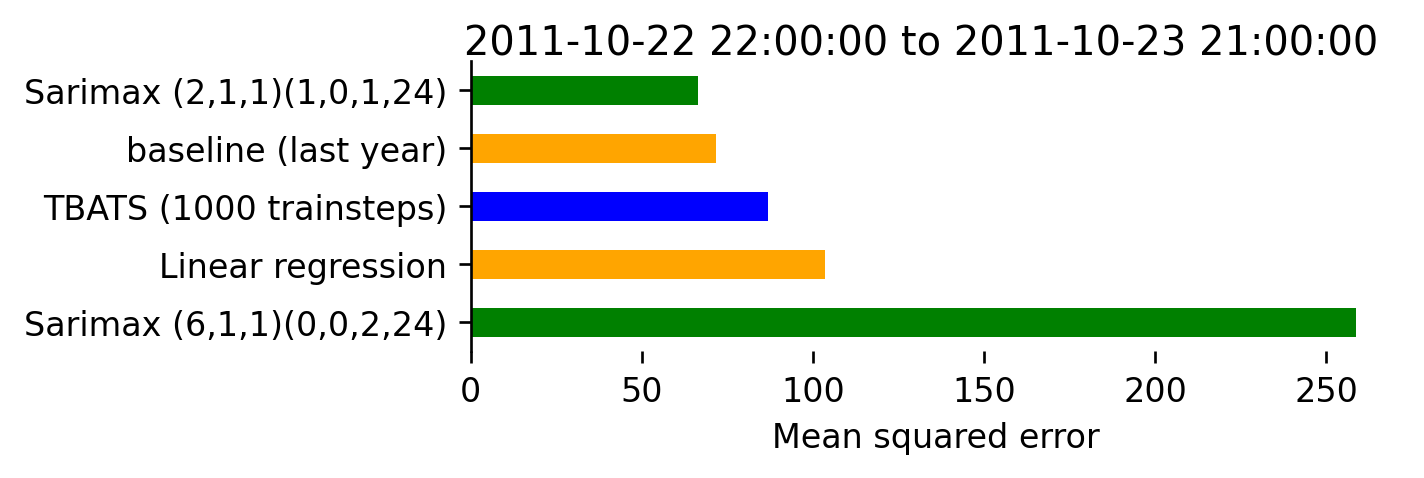

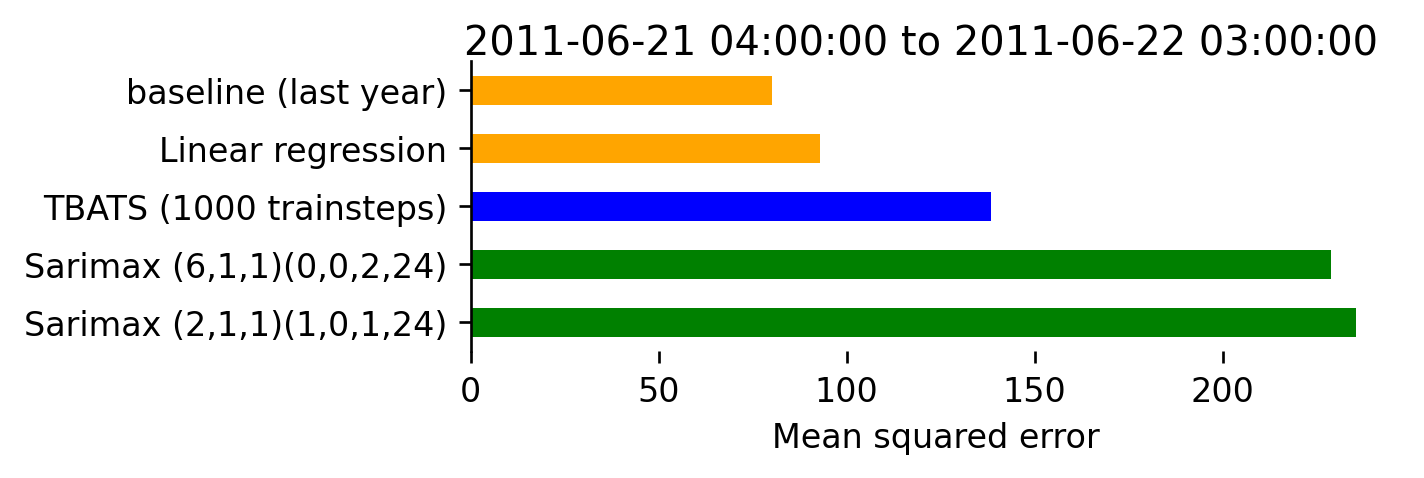

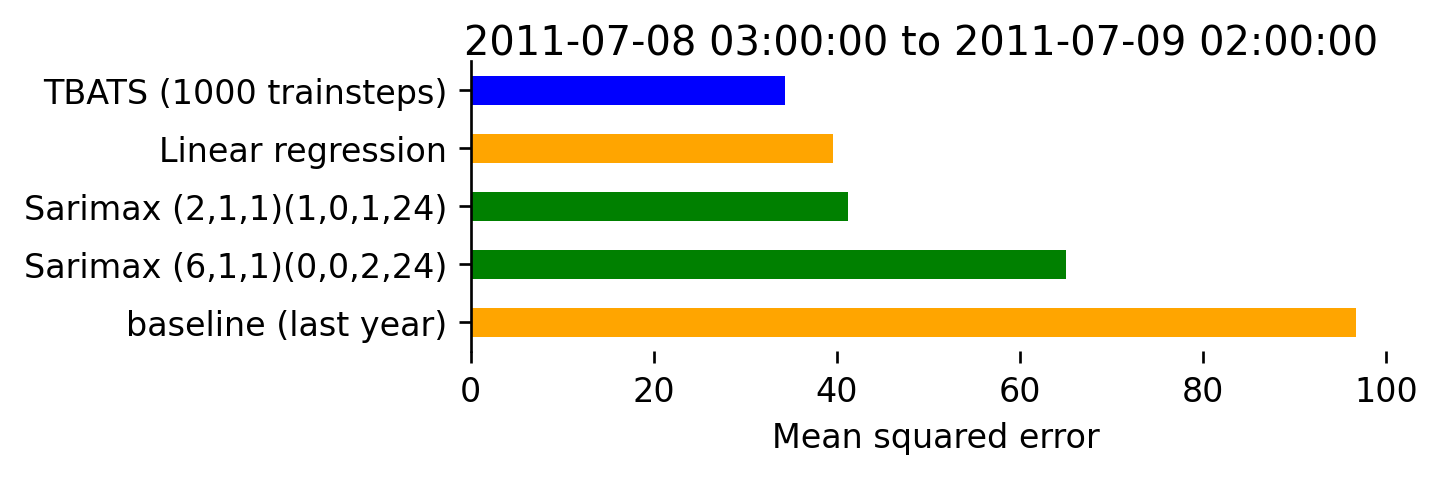

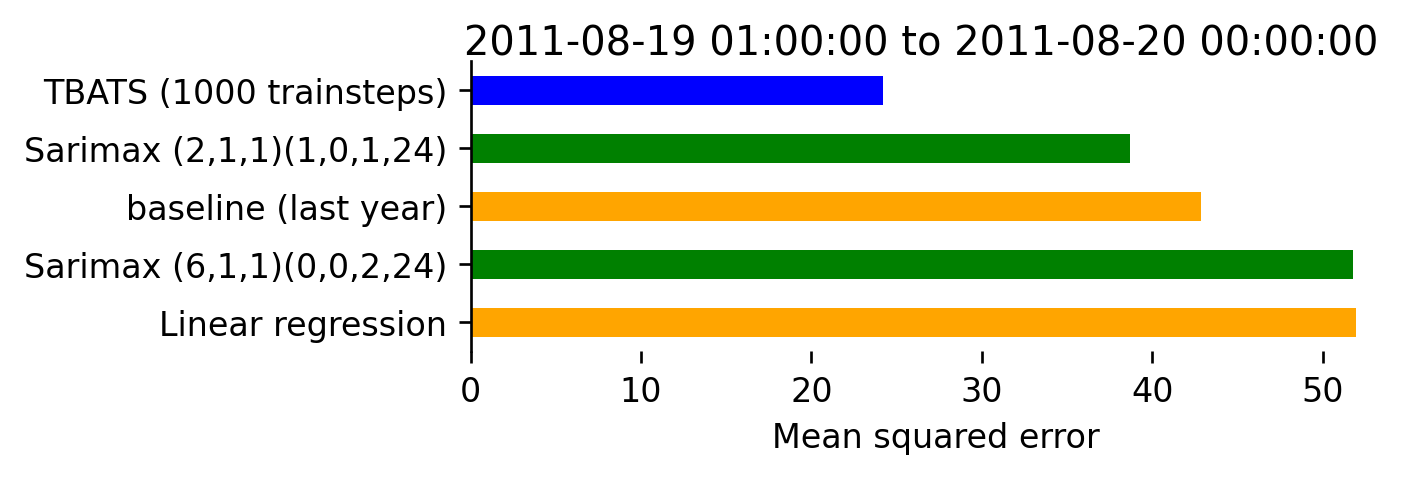

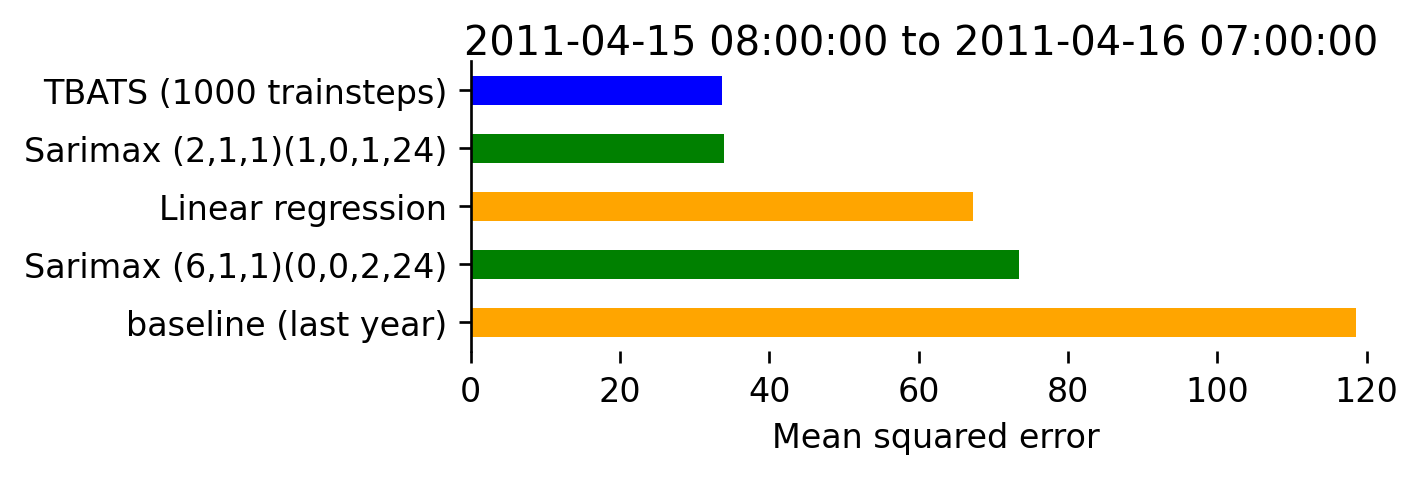

In [56]:
plt.rcParams['figure.figsize'] = [12, 4]

   
model2color = {
    "baseline": "orange",
    "linear_regression": "orange",
    "TBATS": "blue",
    "sarimax": "green",
}

indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]
for index in indices:
    fig, ax = plt.subplots()
    fig.set_figheight(1.6)
    fig.set_figwidth(5)
    fig.set_dpi(240)

    plot_df = (df[df["index"] == index]
                .sort_values("mse", ascending=False)
                .assign(col = lambda x:x["model"].map(lambda x: model2color.get(x, "black")))
                #.assign(label = lambda x: f"{x['model']}{steps2str(x['train_steps'])}")
                .drop_duplicates(subset=["run_name"])
    )
    plot_df.plot.barh(x="disp_label", y="mse", color=plot_df["col"], legend=None, ax=ax)
    #ax.barh(plot_df["mse"], width=20, color=plot_df["col"], legend=None, height=0.9)
    ax.set_xlabel("Mean squared error")
    ax.set_ylabel(None)
    fig.suptitle(f"{str(index2datetime(index+1))} to {str(index2datetime(index+24))}")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [8]:
# Load the actual dataset
def get_df(building_nr, feature):
    df = (
    pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv")
        .astype({'datetime': 'datetime64'})
        [[feature, "datetime"]]
        .rename(columns={feature: "actual"})
    )
    df.index.name = "id"
    return df

actual_df = get_df(5, "net_load_kWh")

In [62]:
plt.rcParams['figure.figsize'] = [25, 6]

index_to_plot = indices[0]
#index_to_plot = indices[1]
plot_df = df[df["index"] == index_to_plot].drop_duplicates(subset=["run_name"])
plot_df

,time_s,mse,mae,r2_score,model,datetime,feature,predicted feature,building nr,resolution,run_name,building_nr,pred_steps,index,train_steps,seasonalities,disp_label
run_id,,,,,,,,,,,,,,,,,
b3196bae3b77455494b6b7a2d4ccc12b,1.17,47.266020,5.106126,0.644495,sarimax,2011-09-01 23:00:00,net_load_kWh,net_load_kWh,5,daily,"sarimax_(2,1,1)(1,0,1,24)",NaN,NaN,32135,NaN,NaN,"Sarimax (2,1,1)(1,0,1,24)"
0cdf014eb5204161bf9cd08c12452eaf,1.22,34.635885,4.679617,0.739491,linear_regression,2011-09-01 23:00:00,net_load_kWh,net_load_kWh,5,daily,linear_regression,NaN,NaN,32135,NaN,NaN,Linear regression
06135845f8f24cc0aac7a4c39e877152,1.31,61.138895,6.664547,0.540152,sarimax,2011-09-01 23:00:00,net_load_kWh,net_load_kWh,5,daily,"sarimax_(6,1,1)(0,0,2,24)",NaN,NaN,32135,NaN,NaN,"Sarimax (6,1,1)(0,0,2,24)"
556a4d90c5de48339ba8352f141ccfb1,1.20,187.675055,11.843212,-0.411574,baseline,2011-09-01 23:00:00,net_load_kWh,NaN,NaN,H,baseline_Y_32135,5,24,32135,NaN,NaN,baseline (last year)
d1fee9b0c54449a4ac9e12dc63f45735,41.56,49.690652,5.179821,0.626258,TBATS,2011-09-01 23:00:00,net_load_kWh,NaN,NaN,H,TBATS_1000,5,24,32135,1000.0,[24],TBATS (1000 trainsteps)


In [63]:
from pandas import concat


df_from_csv_1 = pd.read_csv("../data/results/linear_regression.csv")
df_from_csv_2 = pd.read_csv("../data/results/sarimax_(2,1,1)(1,0,1,24).csv")
df_from_csv = pd.concat([df_from_csv_1, df_from_csv_2], axis=0, ignore_index=True)[["runid", "id", "prediction"]].rename(columns={"runid": "run_id"})
#df_from_csv.head()

[Warning: didn't find 06135845f8f24cc0aac7a4c39e877152 csv data]


Text(0.5, 0.98, 'Net energy usage forecasts')

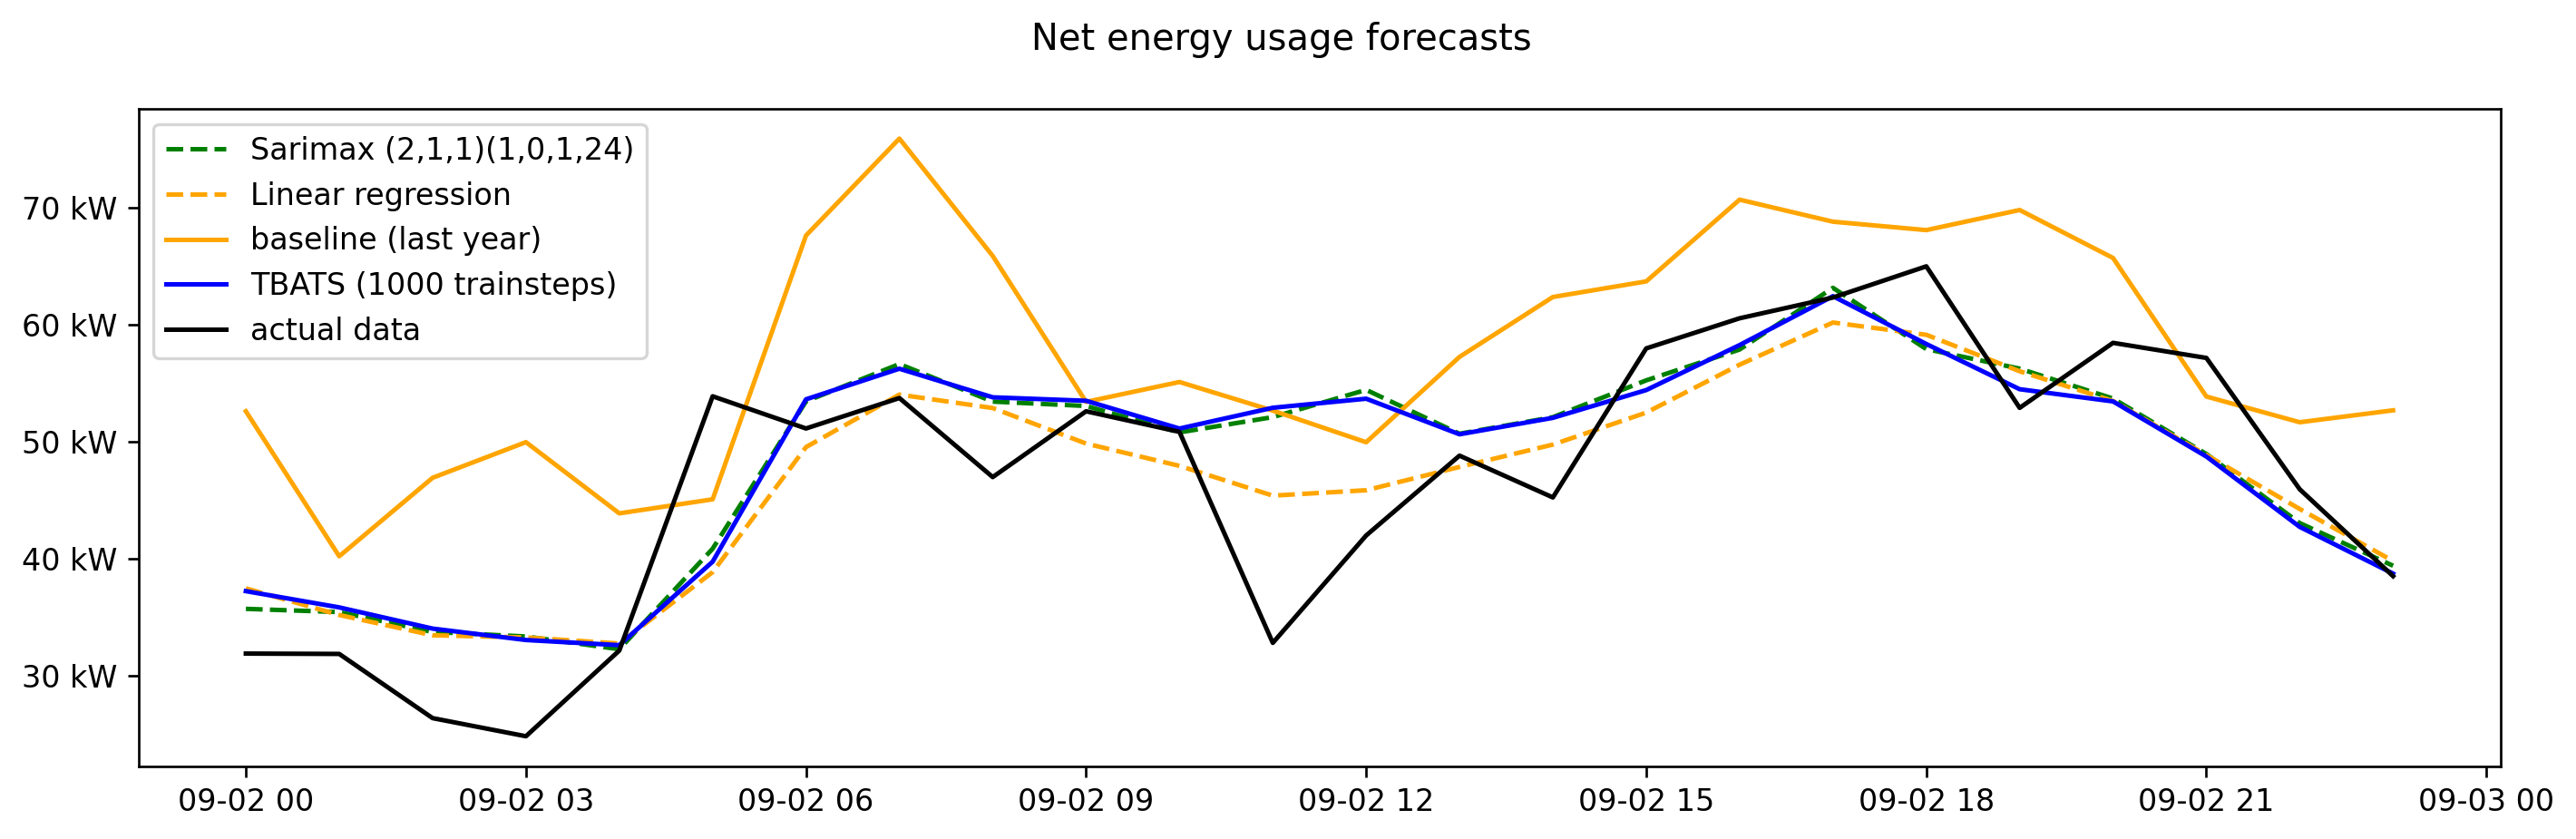

In [65]:
#def y_fmt(x, y):
#    if max_y > 1000000:
#        val = int(y)/1000000
#        return '{:d} M'.format(val)
#    elif max_y > 1000:
#        val = int(y) / 1000
#        return '{:d} k'.format(val)
#    else:
#        return y
import matplotlib.ticker as tick

y_true = actual_df.loc[index_to_plot+1:index_to_plot+24].set_index("datetime")

fig = plt.figure(figsize=(14,4), dpi=240)
ax = fig.add_subplot(111)


for run_id, run_data in plot_df.iterrows():
    plot_kwargs = {}
    query_string = f"SELECT * FROM forecast WHERE run_id='{run_id}'" # LIMIT 10"
    run_predictions = pd.read_sql(query_string, db).drop(columns="run_id")
    if len(run_predictions) == 0:
        #print(f"[INFO: for {run_id}, there is not data in the SQL database.]")
        #print(f"[...trying to read from csv file]")
        run_predictions = df_from_csv[df_from_csv.run_id == run_id].copy().drop(columns="run_id")
        if len(run_predictions) == 0:
            print(f"[Warning: didn't find {run_id} csv data]")
            continue
        if run_data.run_name in ["linear_regression", "sarimax_(2,1,1)(1,0,1,24)"]:
            plot_kwargs = {
                'linestyle': 'dashed'
            }

    run_predictions["datetime"] = run_predictions["id"].map(index2datetime)#y_true.index
    color = model2color.get(run_data.model, "gray")
    ax.plot(run_predictions.drop(columns=["id"]).set_index("datetime"), color=color, label=run_data["disp_label"], **plot_kwargs)
    #ax.plot(run_predictions.drop(columns=["id"]).set_index("datetime"), color=color, label=run_data["disp_label"])
ax.plot(y_true, color="black", label="actual data");
#plt.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
ax.legend()

def y_fmt(x, y):
    return f"{int(x)} kW"
    #return f"x:{x}; y:{y}"
    #return '{:2.2e}'.format(x).replace('e', 'x10^')

ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
fig.suptitle("Net energy usage forecasts")

In [12]:
query_string = "SELECT * FROM forecast" # LIMIT 10"
run_predictions = pd.read_sql(query_string, db)

In [13]:
len(run_predictions)

1968

In [14]:
indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]
times = [(index2datetime(i), i+1, i+24) for i in indices]
display(times)

[(datetime.datetime(2011, 9, 1, 23, 0), 32136, 32159),
 (datetime.datetime(2011, 10, 20, 23, 0), 33312, 33335),
 (datetime.datetime(2011, 1, 9, 6, 0), 26479, 26502),
 (datetime.datetime(2011, 10, 22, 21, 0), 33358, 33381),
 (datetime.datetime(2011, 6, 21, 3, 0), 30388, 30411),
 (datetime.datetime(2011, 7, 8, 2, 0), 30795, 30818),
 (datetime.datetime(2011, 8, 19, 0, 0), 31801, 31824),
 (datetime.datetime(2011, 4, 15, 7, 0), 28784, 28807)]

# upload building data from csv to database

In [15]:
if False:
    building_nr = 5
    df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'})
    df.index.name = "id"
    
    df.to_sql("building5", con=db)